In [14]:
from matplotlib import pyplot as plt
import numpy as np
# import pymatgen as p
# from tblg import tblg

In [57]:
# %load tblg.py

def tblg_nm(n=9,m=8):
    import numpy as np
    from pymatgen.core import Structure
    """Get the pymatgen structure of the twisted bilayer graphene for given n and m.
    angle is given by arccos[ 0.5*(n**2+4*n*m+m**2) / (n**2+n*m+m**2)  ]
    
    Args:
        n (int, optional): sc 1
        m (int, optional): sc 2
    
    Returns:
        TYPE: pymatgen structure object
    """
    def R(t): #Rotation matrix
        c, s = np.cos(t), np.sin(t)
        R = np.array(((c, -s), (s, c)))
        R=np.vstack([R,[0,0]]);R=np.hstack([R,[[0],[0],[1]]])
        return R
    t=np.arccos(0.5* (n**2+4*n*m+m**2) / (n**2+n*m+m**2)  )
    lattice_lower=[3*R(t/2)@i for i in np.array([[1.0,0.0,0],[0.5,np.sqrt(3.0)/2.0,0],[0,0,10]])]  # lower lattice
    lattice_upper=[3*R(-t/2)@i for i in np.array([[1.0,0.0,0],[0.5,np.sqrt(3.0)/2.0,0],[0,0,10]])]  # top lattice
    lower=Structure(lattice=lattice_lower,species=["C","C"],coords=[[1./3.,1./3.,0.5],[2./3.,2./3.,0.5]]) 
    upper=Structure(lattice=lattice_upper,species=["C","C"],coords=[[1./3.,1./3.,0.5],[2./3.,2./3.,0.5]])

    sc=np.eye(3)
    sc[0][0]=n;sc[0][1]=m
    sc[1][0]=-m;sc[1][1]=n+m
    lower.make_supercell(sc) # supercell transfornation matrix for lower system

    sc=np.eye(3)
    sc[0][0]=m;sc[0][1]=n
    sc[1][0]=-n;sc[1][1]=m+n
    upper.make_supercell(sc) # supercell transfornation matrix for upper system


    d=.5  # distance between layers
    pos=[]
    for i in upper:pos.append(i.coords+[0,0,d])
    for i in lower:pos.append(i.coords+[0,0,-d])
    species=["C"]*len(pos)
    tblg=Structure(lattice=upper.lattice,coords=pos,species=species,coords_are_cartesian=True)
    print("angle of twist = {}".format(np.rad2deg(np.arccos(  0.5*(n**2+4*n*m+m**2)/(n**2+n*m+m**2)   ))))
    return tblg #return the twisted bilayer structure

In [58]:
tblg_structure=tblg_nm(4,2)
tblg_structure.to("cif","tblg.cif")
!open tblg.cif

angle of twist = 21.78678929826181


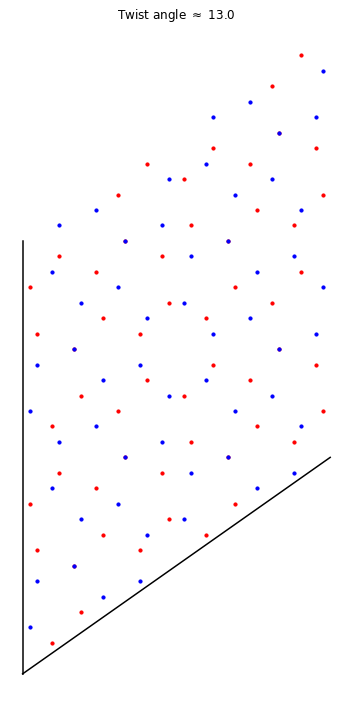

In [59]:
def plot_it(tblg_structure,n,m):
    fig,ax=plt.subplots(figsize=(10*np.cos(np.pi/3),10))
    coords=tblg_structure.cart_coords
    z=np.unique(coords.T[2])
    A=coords[np.where(coords.T[2]==z[0])]
    B=coords[np.where(coords.T[2]==z[1])]
    plt.scatter(A.T[0],A.T[1],c="r",s=10)
    plt.scatter(B.T[0],B.T[1],c="b",s=10)

    a1=tblg_structure.lattice.matrix[0][:-1]
    a2=tblg_structure.lattice.matrix[1][:-1]
    for i in [a1,a2]:plt.plot([0,i[0]],[0,i[1]],c="k")
    ax.set_title("Twist angle $\\approx$ {}".format(np.round(np.rad2deg(np.arccos(  0.5*(n**2+4*n*m+m**2)/(n**2+n*m+m**2)   ))),3))
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("figures/{}_deg.png".format(np.round(np.rad2deg(np.arccos(  0.5*(n**2+4*n*m+m**2)/(n**2+n*m+m**2)   ))),3),dpi=300)
    plt.show()
plot_it(tblg_structure,12,8)

In [60]:
from pysktb import *

In [99]:
def ham_tblg(struc):
    atoms=[]
    for i in struc:
        atoms.append(Atom(i.species_string,i.frac_coords))
    for i in atoms:
        i.set_orbitals(["s"])

    d=0
    lattice=Lattice(struc.lattice.matrix,1)
    interactions={"C":{"e_s":0}
        ,"CC":{"V_sss":-.5}}

    nn=2.6
#     nn=np.unique(np.sort(struc.distance_matrix.flatten()))[1]
    bond={"CC":{"NN":nn}}


    s=Structure(lattice,atoms,bond_cut=bond)
    ham=Hamiltonian(s,interactions,numba=1)
    return ham

In [100]:
ham=ham_tblg(tblg_structure) 

In [101]:
import pickle
with open('tblg.pickle', 'wb') as handle:
    pickle.dump(ham, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tblg.pickle', 'rb') as handle:
    ham = pickle.load(handle)

In [102]:

path=[[0.,0.,0],[1./3.,2./3.,0],[.5,.5,0],[0.,0.,0]]
k_path, k_dist,k_pts=ham.get_kpts(path,60)

eigs_k = []
evals=ham.solve_kpath(k_path)

exception calling callback for <Future at 0x1a29070910 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/joblib/parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/joblib/parallel.py", line 780, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/joblib/parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/joblib/parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/Caskroom/miniconda/base/lib/python3.7/site-

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [ ]:
fig,ax=plt.subplots()
for i in evals:ax.plot(k_dist,i,c="k")
for i in k_pts:ax.axvline(i,c="k",ls=":")
ax.set_xticks(k_pts)
ax.set_xticklabels([r"$\Gamma$","K","M",r"$\Gamma$"])
ax.set_ylim([-.5,.5])
plt.show()

In [103]:
len(tblg_structure)

112